# ISI SPRING 2019 RESEARCH PROJECT 
* By: Huy Nghiem
* Assingment for the spam classifcation project for the USC MINDS research group.
* TASK: Classify whether e-mails are spams or not and produce metrics for model performance. 
* In this module, we explore more advance Machine Learning techniques, __Support Vector Machine__ and __Random Forest__ for the same task.
We aim to see whether these modules do better in terms of __False Positives Rate__ and __False Negative Rate__ , and of course regular metrics. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
%load_ext autoreload
%matplotlib inline

In [2]:
df = pd.read_csv("spambase.data", header=None)
print(df.shape)
feat = df.loc[:,:56].values #Must convert to np array for later use
label = df.loc[:,57].values

(4601, 58)


## Training, Valdiation and Testing
In the LR module, simple cross validation was used to produce average statistics. 

In this module, we go one step further by first splitting the data into training and testing set. This test set is considered a black box, where its function is really just to be a basis for model evaluation. 
The models to be used require tuning for hyperparameters, a process to be done on validation set(s).

In [3]:
from sklearn.decomposition import PCA
x_train, x_test, y_train, y_test = train_test_split(feat,label,test_size=0.3)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3220, 57) (3220,)
(1381, 57) (1381,)


## RANDOM FOREST
Random Forest model predicts labels by combining the votes of random classification trees. RF is robust to deal with multi-collinearity compared to LR.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve

In [5]:
rf = RandomForestClassifier()
#This dictionary is a list of estimators in a tree to search
params_rf =  {'n_estimators':[20,50,75]}

rf_gs = GridSearchCV(rf, params_rf, cv=5)
rf_gs.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [20, 50, 75]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [6]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    rf_best_params = rf_gs.best_estimator_

Grid Search uses cross-validation to find the best hyperparameters.
The result is posted below.

In [7]:
rf_best_params

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
train_y_pred = rf_gs.predict(x_train)
test_y_pred = rf_gs.predict(x_test)
test_y_prob = rf_gs.predict_proba(x_test)

### Model Evaluation

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, accuracy_score

In [10]:
train_acc = round(rf_gs.score(x_train,y_train)*100,2)
test_acc = round(rf_gs.score(x_test,y_test)*100,2)
tn, fp, fn, tp = confusion_matrix(y_test, test_y_pred).ravel()

In [11]:
print("Training Accuracy is {} %, Testing Accuracy is {} %".format(train_acc,test_acc))

Training Accuracy is 99.88 %, Testing Accuracy is 95.73 %


In [12]:
print("TN:%s, FP:%s, FN:%s, TP:%s" % (tn,fp,fn,tp))
print("FPR: {}, FNR: {}".format(round(fp/(fp+tn),2),round(fn/(fn+tp),2)))

TN:816, FP:21, FN:38, TP:506
FPR: 0.03, FNR: 0.07


In [13]:
print(classification_report(y_test, test_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       837
           1       0.96      0.93      0.94       544

   micro avg       0.96      0.96      0.96      1381
   macro avg       0.96      0.95      0.96      1381
weighted avg       0.96      0.96      0.96      1381



The classificatin report and FPR calcuclated are identical, giving us futher 
validation that our calculations are on point. Our RF model achieves a testing 
accuracy at 95%, which is slightly better than our LR model. However, the FPR 
and FNR are comparable.

### Area Under the ROC Curve
Since now we have a hold out testing set, we can explore other performace metrics.  One popular graphical tool to visualize performance for binary classificaition problems is the Receving-Operating Characteristic curve, or ROC, which graphs the False Positive Rate and False Negative Rate at different thresholds.

A perfect model will has an area under the curve, AUC, of 1. Classifying by chance (flipping a coin) has a AUC of 0.5. Ideally, we want our ROC to hug the leftmost corner of the grid as much mas possible.

In [14]:
def get_ROC(y_test, probs):
    auc = roc_auc_score(y_test, probs[:,1])
    fpr, tpr, thresh = roc_curve(y_test, probs[:,1])
    plt.plot([0,1],[0,1],linestyle='--')
    print("AUC =",auc)
    plt.plot(fpr,tpr,marker='.')
    return auc, fpr, tpr

AUC = 0.9859211381685291


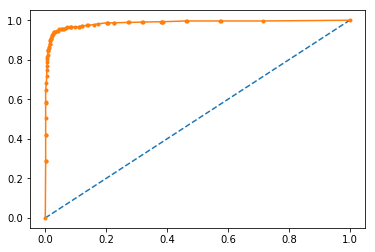

In [15]:
auc, fpr, tpr = get_ROC(y_test, test_y_prob)

With an AUC of 0.98 , our model achieves near perfect classification rate
on the test set. For other existing metrics, it appears that the RF model 
did slightly better at correctly identifying __spam__ vs. __non-spam__ than 
the LR model.

## SUPPORT VECTOR MACHINE
Support Vector Machine technique identifies support vectors to best identify hyperplanes that separate/classify the data. In practice, SVM with linear kernel performs similarly to LR. So in this exercise, we will Random Search Cross-validation to identify the best paremeters, including which kernel to use.

In [16]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

In [17]:
svc = SVC(probability=True)
params_svc = {'kernel': ['rbf','sigmoid'], 'gamma':[1e-2,1e-3,1e-4],
              'C': [0.001,0.1,1,10]
             }
svm_rs  = RandomizedSearchCV(svc,params_svc)
svm_rs.fit(x_train,y_train)

/Users/AdrianTran/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'kernel': ['rbf', 'sigmoid'], 'gamma': [0.01, 0.001, 0.0001], 'C': [0.001, 0.1, 1, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [18]:
svm_rs.best_params_

{'kernel': 'rbf', 'gamma': 0.01, 'C': 10}

In [19]:
train_y_pred = svm_rs.predict(x_train)
test_y_pred = svm_rs.predict(x_test)
test_y_prob = svm_rs.predict_proba(x_test)

## Model Evaluation

In [20]:
train_acc = round(rf_gs.score(x_train,y_train)*100,2)
test_acc = round(rf_gs.score(x_test,y_test)*100,2)
tn, fp, fn, tp = confusion_matrix(y_test, test_y_pred).ravel()

In [21]:
print("Training Accuracy is {} %, Testing Accuracy is {} %".format(train_acc,test_acc))

Training Accuracy is 99.88 %, Testing Accuracy is 95.73 %


In [22]:
print("TN:%s, FP:%s, FN:%s, TP:%s" % (tn,fp,fn,tp))
print("FPR: {}, FNR: {}".format(round(fp/(fp+tn),2),round(fn/(fn+tp),2)))

TN:725, FP:112, FN:67, TP:477
FPR: 0.13, FNR: 0.12


In [23]:
print(classification_report(y_test, test_y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89       837
           1       0.81      0.88      0.84       544

   micro avg       0.87      0.87      0.87      1381
   macro avg       0.86      0.87      0.87      1381
weighted avg       0.87      0.87      0.87      1381



AUC = 0.9337312882142104


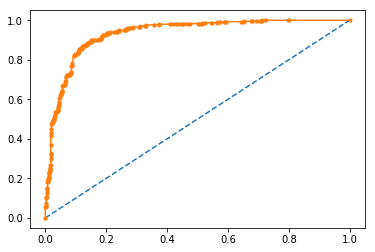

In [24]:
auc, fpr, tpr = get_ROC(y_test, test_y_prob)

With an [rfb] kernel, we see that the SVM model performs less well as comparing 
to the RF model. More significantly, this model does worse in terms of FPR than all other models. 

## FINAL REMARK

Overall this dataset seems rather straight forward. This dataset is already processed and the number of features are sufficient to achieve a high-level materials of classification.  

This fortunate fact is not entirely surprising, as the dataset measures the frequency of words typically associated with spams! 

From a technical persepctive, there are a few items of enhancement: 
* Combine cross-validation for both validation and testing. That is,
we can split the set using k_fold, and at each fold for training, we can cross-validate on this subset even further.
* Classification problem typically benefits from an ensemnle model, when each data point (email) is classified by the combined result of various models/techniques.

__****END OF MODULE****__